In [1]:
import numpy as np
import matplotlib.pyplot as plt
import edrixs
from scipy.linalg import eigh
from edrixs_utils import calc_XAS_Q0, calc_RIXS_Q0, get_tdd
from misc import table, make_theme

In [2]:
%matplotlib inline
plt.rcParams['font.size'] = 7

In [3]:
def solve_2TM(nhole=2, vector_d=[0.,0.,1.],
              tenDq=0., Deg=0., Dt2g=0., c_soc=13.4977, Vdd_sigma=1.,
              U_dd=9., U_dp=8.5, Udd_screen=0.8, Udp_screen=0.8,
              eloss=np.arange(-1.,15.01,0.01)):

    Vdd_pi = -0.5 * Vdd_sigma
    Vdd_delta = 0.
    F2_dd = 13.612 * Udd_screen
    F4_dd = 8.458 * Udd_screen
    F2_dp = 8.178 * Udp_screen
    G1_dp = 6.17 * Udp_screen
    G3_dp = 3.511
    F0_dd = U_dd - 4.0 / 49.0 * F2_dd - 4.0 / 49.0 * F4_dd
    F0_dp = U_dp + edrixs.get_F0('dp', G1_dp, G3_dp)
    
    print('----> Constructing Hamiltonian...')
    # atom positions
    l = np.dot(vector_d, [1.,0.,0.])/np.linalg.norm(vector_d)
    m = np.dot(vector_d, [0.,1.,0.])/np.linalg.norm(vector_d)
    n = np.dot(vector_d, [0.,0.,1.])/np.linalg.norm(vector_d)
    tdd_sigma, tdd_pi, tdd_delta = get_tdd(l, m, n)

    # emat
    ## spin unresolved
    emat_tmp = np.zeros((10, 10), dtype=complex)
    emat_tmp[:5,:5] += np.diag([Deg, tenDq+Dt2g, tenDq+Dt2g, 0., tenDq]) # CEF for Cu1
    emat_tmp[5:,5:] += np.diag([Deg, tenDq+Dt2g, tenDq+Dt2g, 0., tenDq]) # CEF for Cu1
    emat_tmp[:5,5:] += tdd_sigma * Vdd_sigma + tdd_pi * Vdd_pi + tdd_delta * Vdd_delta # hopping
    emat_tmp[5:,:5] += tdd_sigma * Vdd_sigma + tdd_pi * Vdd_pi + tdd_delta * Vdd_delta # hopping
    ## transform to complex basis
    tmat = np.zeros((10,10), dtype=complex)
    tmat[:5,:5] = edrixs.tmat_r2c('d', False)
    tmat[5:,5:] = edrixs.tmat_r2c('d', False)
    emat_tmp = edrixs.cb_op(emat_tmp, tmat)
    ## spin resolved
    emat_i = np.zeros((32, 32), dtype=complex) # order: Cu1_3d, Cu2_3d, Cu1_2p, Cu2_2p
    emat_n = np.zeros((32, 32), dtype=complex)
    emat_i[:20:2,:20:2] += emat_tmp
    emat_i[1:20:2,1:20:2] += emat_tmp
    emat_n[:20:2,:20:2] += emat_tmp
    emat_n[1:20:2,1:20:2] += emat_tmp
    emat_n[20:26,20:26] += edrixs.atom_hsoc('p', -c_soc)
    emat_n[26:,26:] += edrixs.atom_hsoc('p', -c_soc)

    # umat
    ## umat_i
    umat_i = np.zeros((32, 32, 32, 32), dtype=complex)
    umat_tmp = edrixs.get_umat_slater('d', F0_dd, F2_dd, F4_dd)
    umat_i[:10,:10,:10,:10] += umat_tmp
    umat_i[10:20,10:20,10:20,10:20] += umat_tmp
    ## umat_n
    umat_n = np.zeros((32, 32, 32, 32), dtype=complex)
    umat_tmp = edrixs.get_umat_slater('dp', F0_dd, F2_dd, F4_dd, F0_dp, F2_dp, G1_dp, G3_dp, 0., 0.)
    indxs = [np.hstack([np.arange(10), np.arange(20,26)]), np.hstack([np.arange(10,20), np.arange(26,32)])]
    for indx in indxs:
        for n1 in range(16):
            for n2 in range(16):
                for n3 in range(16):
                    for n4 in range(16):
                        umat_n[indx[n1],indx[n2],indx[n3],indx[n4]] += umat_tmp[n1,n2,n3,n4]

    # basis
    basis_i = edrixs.get_fock_bin_by_N(20, nhole, 12, 0)
    basis_n = edrixs.get_fock_bin_by_N(20, nhole-1, 12, 1)

    # hmat
    hmat_i = edrixs.four_fermion(umat_i, basis_i) + edrixs.two_fermion(emat_i, basis_i)
    hmat_n = edrixs.four_fermion(umat_n, basis_n) + edrixs.two_fermion(emat_n, basis_n)

    # diag
    print('----> Solving Hamiltonian...')
    evals_i, evecs_i = eigh(hmat_i)
    evals_n, evecs_n = eigh(hmat_n)

    # construct Tabs
    ncfg_i, ncfg_n = len(basis_i), len(basis_n)
    dipole = np.zeros((3, 32, 32), dtype=complex)
    T_abs = np.zeros((3, ncfg_n, ncfg_i), dtype=complex)
    tmp = edrixs.get_trans_oper('dp')
    for i in range(3):
        dipole[i, 20:26, :10] = np.conj(np.transpose(tmp[i]))
        dipole[i, 26:, 10:20] = np.conj(np.transpose(tmp[i]))
        T_abs[i] = edrixs.two_fermion(dipole[i], basis_n, basis_i)
        T_abs[i] = edrixs.cb_op2(T_abs[i], evecs_n, evecs_i)

    # occupation
    print('----> Calculating occupation...')
    nd_real_harmoic_basis = np.zeros((32, 32, 32), dtype=complex)
    indx = np.arange(32)
    nd_real_harmoic_basis[indx, indx, indx] = 1
    tmat = np.zeros((32,32), dtype=complex)
    tmat[:10,:10]     = edrixs.tmat_r2c('d', True)
    tmat[10:20,10:20] = edrixs.tmat_r2c('d', True)
    tmat[20:26,20:26] = edrixs.tmat_r2c('p', True)
    tmat[26:,26:]     = edrixs.tmat_r2c('p', True)
    nd_complex_harmoic_basis = edrixs.cb_op(nd_real_harmoic_basis, tmat)
    nd_op = edrixs.build_opers(2, nd_complex_harmoic_basis, basis_i)
    nd_expt = np.array([edrixs.cb_op(nd_vec, evecs_i).diagonal().real for nd_vec in nd_op])

    # momentum
    print('----> Calculating momentum...')
    orb_mom  = np.zeros((3, 32, 32), dtype=complex)
    spin_mom = np.zeros((3, 32, 32), dtype=complex)
    orb_mom[:,:10,:10]      += edrixs.get_orb_momentum(2, ispin=True)
    orb_mom[:,10:20,10:20]  += edrixs.get_orb_momentum(2, ispin=True)
    spin_mom[:,:10,:10]     += edrixs.get_spin_momentum(2)
    spin_mom[:,10:20,10:20] += edrixs.get_spin_momentum(2)
    tot_mom = orb_mom + spin_mom

    opL, opS, opJ = edrixs.build_opers(2, [orb_mom, spin_mom, tot_mom], basis_i)
    L2 = np.dot(opL[0], opL[0]) + np.dot(opL[1], opL[1]) + np.dot(opL[2], opL[2])
    S2 = np.dot(opS[0], opS[0]) + np.dot(opS[1], opS[1]) + np.dot(opS[2], opS[2])
    J2 = np.dot(opJ[0], opJ[0]) + np.dot(opJ[1], opJ[1]) + np.dot(opJ[2], opJ[2])
    L2_val = edrixs.cb_op(L2, evecs_i).diagonal().real
    S2_val = edrixs.cb_op(S2, evecs_i).diagonal().real
    J2_val = edrixs.cb_op(J2, evecs_i).diagonal().real
    L = (-1 + np.sqrt(1 + 4*L2_val))/2
    S = (-1 + np.sqrt(1 + 4*S2_val))/2
    J = (-1 + np.sqrt(1 + 4*J2_val))/2
    
    # summary
    summary = dict(E=evals_i, S=S, L=L, J=J,
                   Cu1_dz2=nd_expt[0,:]+nd_expt[1,:], Cu1_dxz=nd_expt[2,:]+nd_expt[3,:],
                   Cu1_yz=nd_expt[4,:]+nd_expt[5,:], Cu1_x2=nd_expt[6,:]+nd_expt[7,:],
                   Cu1_xy=nd_expt[8,:]+nd_expt[9,:],
                   Cu2_dz2=nd_expt[10,:]+nd_expt[11,:], Cu2_dxz=nd_expt[12,:]+nd_expt[13,:],
                   Cu2_yz=nd_expt[14,:]+nd_expt[15,:], Cu2_x2=nd_expt[16,:]+nd_expt[17,:],
                   Cu2_xy=nd_expt[18,:]+nd_expt[19,:])
    
    # XAS
    omega = np.linspace(-10,20,3000)
    xas = calc_XAS_Q0(evals_i, evals_n, T_abs, Gam_c=0.6, omega=omega, pol=[1.0, 1.0, 1.0])
    omega0 = omega[np.argmax(xas)]
    
    # RIXS
    print('----> Calculating RIXS')
    rixs = np.zeros((3,3,len(eloss)), dtype=float)
    for nei in range(3):
        for nef in range(3):
            ei, ef = [0.,0.,0.], [0.,0.,0.]
            ei[nei] = 1.
            ef[nef] = 1.
            rixs_tmp = calc_RIXS_Q0(evals_i, evals_n, T_abs, Gam_c=0.6, sigma=0.05, fraction=0.,
                                    omega=omega0, eloss=eloss, ei=ei, ef=ef).sum(axis=0)
            rixs[nei,nef,:] = rixs_tmp
    print('----> Done!')
    
    return evals_i, evecs_i, evals_n, evecs_n, T_abs, summary, rixs

In [4]:
eloss = np.arange(-1.,15.01,0.01)
vector_d = [0.,0.,1.]

CEF = dict(tenDq=0., Deg=0., Dt2g=0.)
evals_i, evecs_i, evals_n, evecs_n, T_abs, summary, rixs = solve_2TM(nhole=2, vector_d=vector_d,
    c_soc=13.4977, Vdd_sigma=1., U_dd=9., U_dp=8.5, Udd_screen=0.8, Udp_screen=0.8, eloss=eloss, **CEF)
case1 = dict(CEF=CEF, summary=summary, rixs=rixs)

CEF = dict(tenDq=1., Deg=0.6, Dt2g=0.)
evals_i, evecs_i, evals_n, evecs_n, T_abs, summary, rixs = solve_2TM(nhole=2, vector_d=vector_d,
    c_soc=13.4977, Vdd_sigma=1., U_dd=9., U_dp=8.5, Udd_screen=0.8, Udp_screen=0.8, eloss=eloss, **CEF)
case2 = dict(CEF=CEF, summary=summary, rixs=rixs)

CEF = dict(tenDq=1., Deg=-0.6, Dt2g=0.)
evals_i, evecs_i, evals_n, evecs_n, T_abs, summary, rixs = solve_2TM(nhole=2, vector_d=vector_d,
    c_soc=13.4977, Vdd_sigma=1., U_dd=9., U_dp=8.5, Udd_screen=0.8, Udp_screen=0.8, eloss=eloss, **CEF)
case3= dict(CEF=CEF, summary=summary, rixs=rixs)

----> Constructing Hamiltonian...
----> Solving Hamiltonian...
----> Calculating occupation...
----> Calculating momentum...
----> Calculating RIXS
----> Done!
----> Constructing Hamiltonian...
----> Solving Hamiltonian...
----> Calculating occupation...
----> Calculating momentum...
----> Calculating RIXS
----> Done!
----> Constructing Hamiltonian...
----> Solving Hamiltonian...
----> Calculating occupation...
----> Calculating momentum...
----> Calculating RIXS
----> Done!


In [5]:
# table(case1['summary'], select=20, caption='10Dq={:.1f}, Deg={:.1f}, Dt2g={:.1f}'.format(case1['CEF']['tenDq'], case1['CEF']['Deg'], case1['CEF']['Dt2g']))
# table(case2['summary'], select=20, caption='10Dq={:.1f}, Deg={:.1f}, Dt2g={:.1f}'.format(case2['CEF']['tenDq'], case2['CEF']['Deg'], case2['CEF']['Dt2g']))
# table(case3['summary'], select=20, caption='10Dq={:.1f}, Deg={:.1f}, Dt2g={:.1f}'.format(case3['CEF']['tenDq'], case3['CEF']['Deg'], case3['CEF']['Dt2g']))

Text(0.5, 0.98, '2 Cu atoms stacking along $z$ direction')

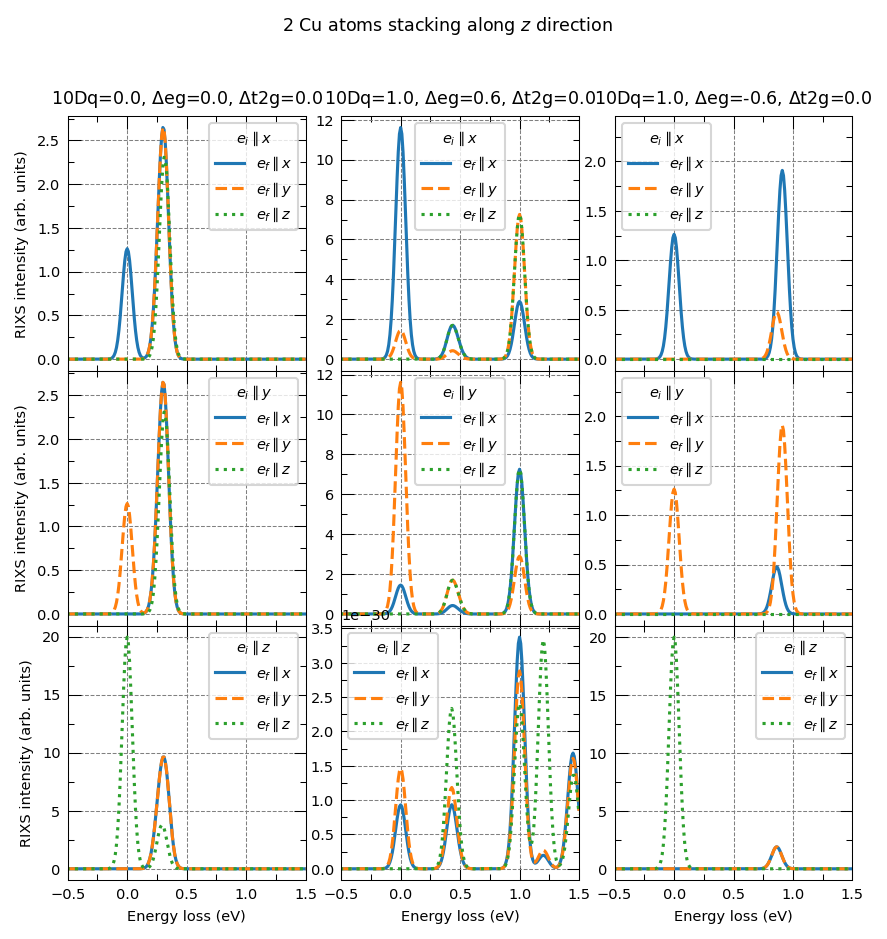

In [6]:
legend_titles = [r'$e_i \parallel x$',r'$e_i \parallel y$',r'$e_i \parallel z$']

fig, axs = plt.subplots(3, 3, figsize=(6.75,6.75), dpi=150, sharex=True, gridspec_kw=dict(hspace=0., wspace=0.15))

for ncase, case in enumerate([case1,case2,case3]):
    for nei in range(3):
        axs[nei,ncase].plot(eloss, case['rixs'][nei,0,:], '-', label=r'$e_f \parallel x$')
        axs[nei,ncase].plot(eloss, case['rixs'][nei,1,:], '--', label=r'$e_f \parallel y$')
        axs[nei,ncase].plot(eloss, case['rixs'][nei,2,:], ':', label=r'$e_f \parallel z$')
        axs[nei,ncase].legend(title=legend_titles[nei])
        make_theme(axs[nei,ncase], grid='--')
    axs[0,ncase].set_title(r'10Dq={:.1f}, $\Delta$eg={:.1f}, $\Delta$t2g={:.1f}'.format(case['CEF']['tenDq'], case['CEF']['Deg'], case['CEF']['Dt2g']))

axs[-1,-1].set_xlim(-0.5,1.5)
for ax in axs[:,0]: ax.set_ylabel('RIXS intensity (arb. units)')
for ax in axs[-1,:]: ax.set_xlabel('Energy loss (eV)')
fig.suptitle('2 Cu atoms stacking along $z$ direction')

In [7]:
eloss = np.arange(-1.,15.01,0.01)
vector_d = [1.,0.,0.]

CEF = dict(tenDq=0., Deg=0., Dt2g=0.)
evals_i, evecs_i, evals_n, evecs_n, T_abs, summary, rixs = solve_2TM(nhole=2, vector_d=vector_d,
    c_soc=13.4977, Vdd_sigma=1., U_dd=9., U_dp=8.5, Udd_screen=0.8, Udp_screen=0.8, eloss=eloss, **CEF)
case1 = dict(CEF=CEF, summary=summary, rixs=rixs)

CEF = dict(tenDq=1., Deg=0.6, Dt2g=0.)
evals_i, evecs_i, evals_n, evecs_n, T_abs, summary, rixs = solve_2TM(nhole=2, vector_d=vector_d,
    c_soc=13.4977, Vdd_sigma=1., U_dd=9., U_dp=8.5, Udd_screen=0.8, Udp_screen=0.8, eloss=eloss, **CEF)
case2 = dict(CEF=CEF, summary=summary, rixs=rixs)

CEF = dict(tenDq=1., Deg=-0.6, Dt2g=0.)
evals_i, evecs_i, evals_n, evecs_n, T_abs, summary, rixs = solve_2TM(nhole=2, vector_d=vector_d,
    c_soc=13.4977, Vdd_sigma=1., U_dd=9., U_dp=8.5, Udd_screen=0.8, Udp_screen=0.8, eloss=eloss, **CEF)
case3= dict(CEF=CEF, summary=summary, rixs=rixs)

----> Constructing Hamiltonian...
----> Solving Hamiltonian...
----> Calculating occupation...
----> Calculating momentum...
----> Calculating RIXS
----> Done!
----> Constructing Hamiltonian...
----> Solving Hamiltonian...
----> Calculating occupation...
----> Calculating momentum...
----> Calculating RIXS
----> Done!
----> Constructing Hamiltonian...
----> Solving Hamiltonian...
----> Calculating occupation...
----> Calculating momentum...
----> Calculating RIXS
----> Done!


Text(0.5, 0.98, '2 Cu atoms stacking along $x$ direction')

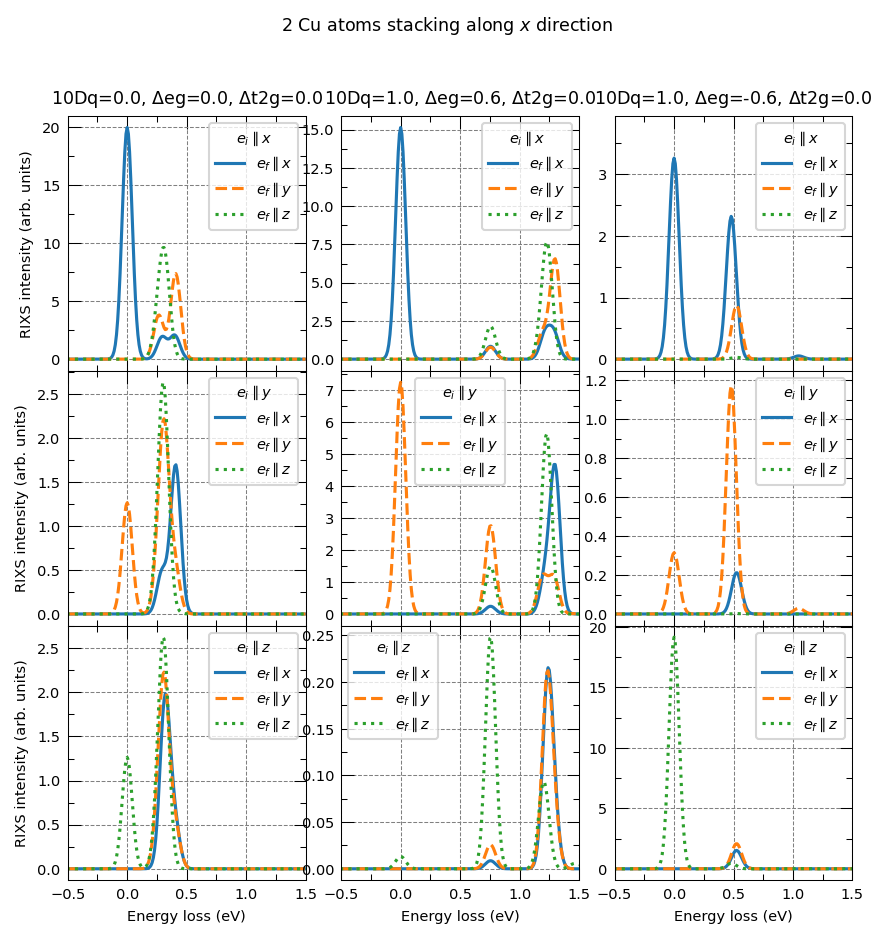

In [8]:
legend_titles = [r'$e_i \parallel x$',r'$e_i \parallel y$',r'$e_i \parallel z$']

fig, axs = plt.subplots(3, 3, figsize=(6.75,6.75), dpi=150, sharex=True, gridspec_kw=dict(hspace=0., wspace=0.15))

for ncase, case in enumerate([case1,case2,case3]):
    for nei in range(3):
        axs[nei,ncase].plot(eloss, case['rixs'][nei,0,:], '-', label=r'$e_f \parallel x$')
        axs[nei,ncase].plot(eloss, case['rixs'][nei,1,:], '--', label=r'$e_f \parallel y$')
        axs[nei,ncase].plot(eloss, case['rixs'][nei,2,:], ':', label=r'$e_f \parallel z$')
        axs[nei,ncase].legend(title=legend_titles[nei])
        make_theme(axs[nei,ncase], grid='--')
    axs[0,ncase].set_title(r'10Dq={:.1f}, $\Delta$eg={:.1f}, $\Delta$t2g={:.1f}'.format(case['CEF']['tenDq'], case['CEF']['Deg'], case['CEF']['Dt2g']))

axs[-1,-1].set_xlim(-0.5,1.5)
for ax in axs[:,0]: ax.set_ylabel('RIXS intensity (arb. units)')
for ax in axs[-1,:]: ax.set_xlabel('Energy loss (eV)')
fig.suptitle('2 Cu atoms stacking along $x$ direction')